In [2]:
Нам предлагается предсказать стоимость дома полагаясь на 79 пояснительных переменных, описывающих почти каждый аспект жилых домов в Эймесе, штат Айова.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Знакомство с данными

Данные содержат чсиловые и категориальные признаки. Признак SalePrice является целевым, его и будем предсказывать. Имеются пропуски NaN.

In [6]:
df = pd.concat([train.drop(['SalePrice'], axis = 1), test], axis = 0)

In [8]:
y_train = train['SalePrice']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 80 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

Итак, у нас есть 37 числовых и 43 категориальных признаков. Видно, что есть признаки с огромным кол-вом пропусков, скорее всего будем от них избавляться. Однако рассмотреть придется каждый признак. Для удобства будем рассматривать численные и категориальные признаки по отдельности.

In [13]:
num_feat = df.select_dtypes(exclude = ['O']).drop(['MSSubClass'], axis = 1).copy()
cat_feat = df.select_dtypes(include = ['O']).copy()
cat_feat['MSSubClass'] = df['MSSubClass'] # MSSubClass является категориальным признаком хоть и записан в виде числа

### Анализ численных признаков

Имеющиеся численные признаки можно разбить на две части, и посмотреть на них отдельно. У нас есть стобцы, значения которых распределяются среди небольшого кол-ва значений. Например кол-во ванных комнат. И более распределенные признаки, например площадь участка в квадратных футах.

In [14]:
num_easy = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
            'MoSold', 'YrSold']
num_hard = []
for col in num_feat.columns:
    if col not in num_easy:
        num_hard.append(col)

Для числовых признак важно посмотреть на их распределение, а также на их статистические характеристики. Для визуализации я использую Distplot. Для поиска артефактов Boxplots.


In [15]:
len(num_hard)

23

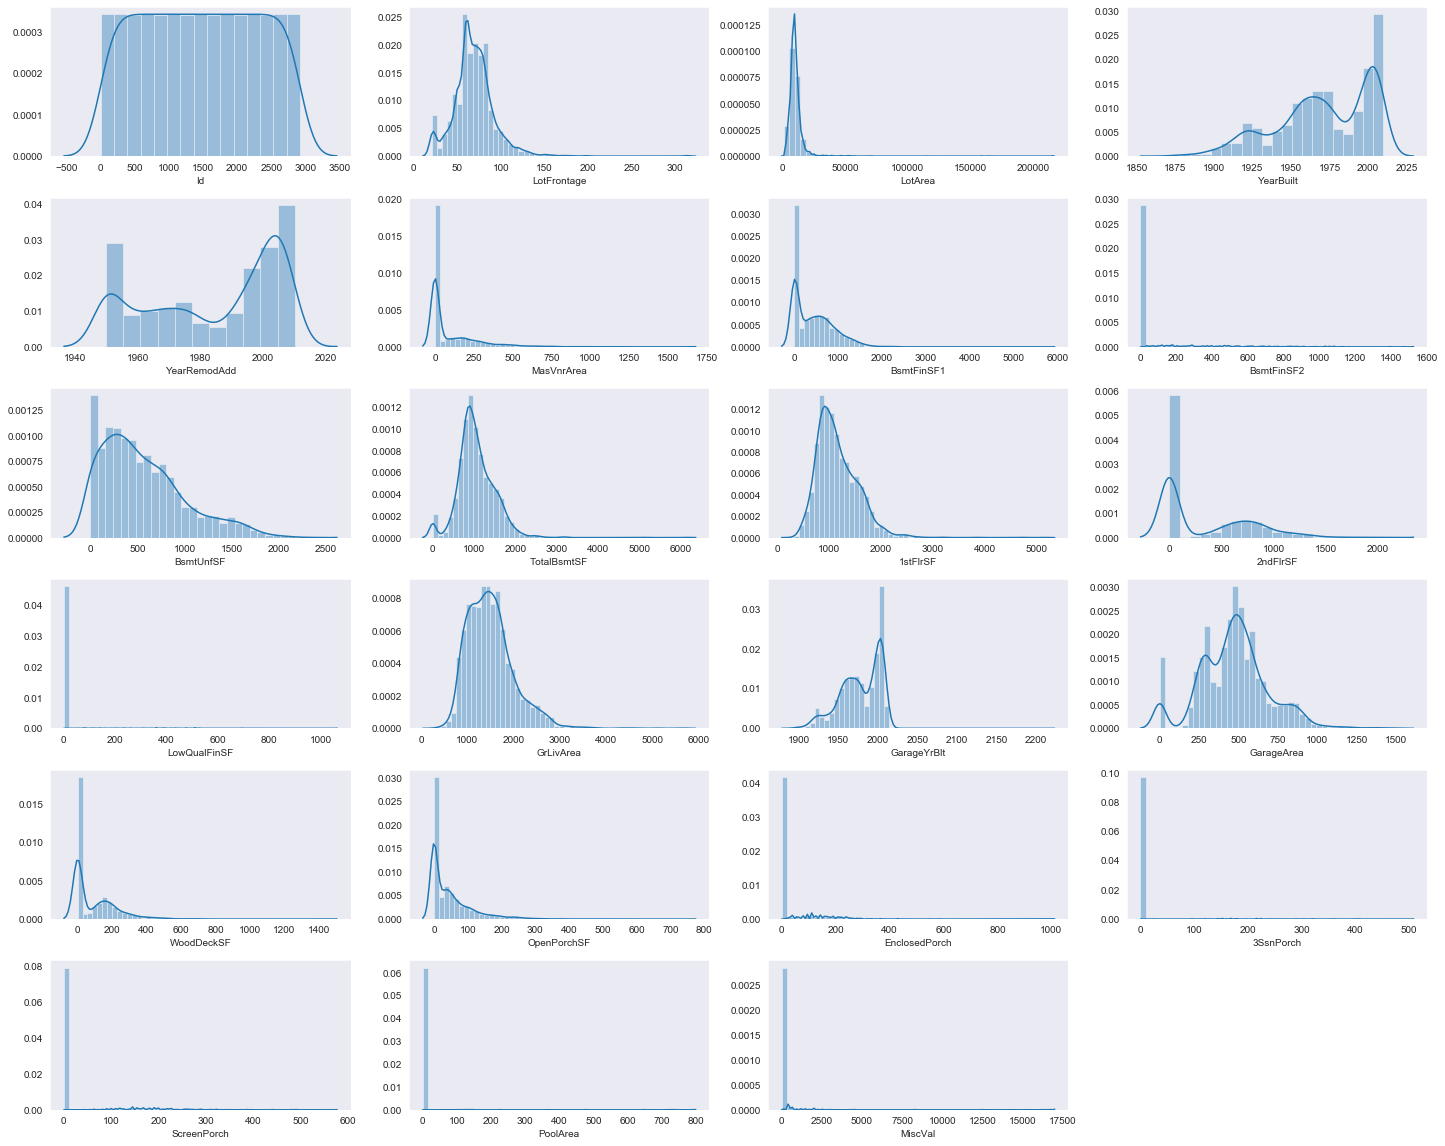

In [30]:
sns.set_style('dark')
fig = plt.figure(figsize = (20,16))
for index, col in enumerate(num_hard):
    plt.subplot(6,4, index+1)
    sns.distplot(num_feat.loc[:, col].dropna())
fig.tight_layout(pad = 1)

Признаки BsmtFinSF2 LowQualFinSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal принимают значение 0 почти по всей выборке. Для модели такие данные не несут никакой роли. Их следует удалить.


С помощью boxplot построим графики плотности распределения значений признаков, чтобы увидеть есть ли в данных выбросы.

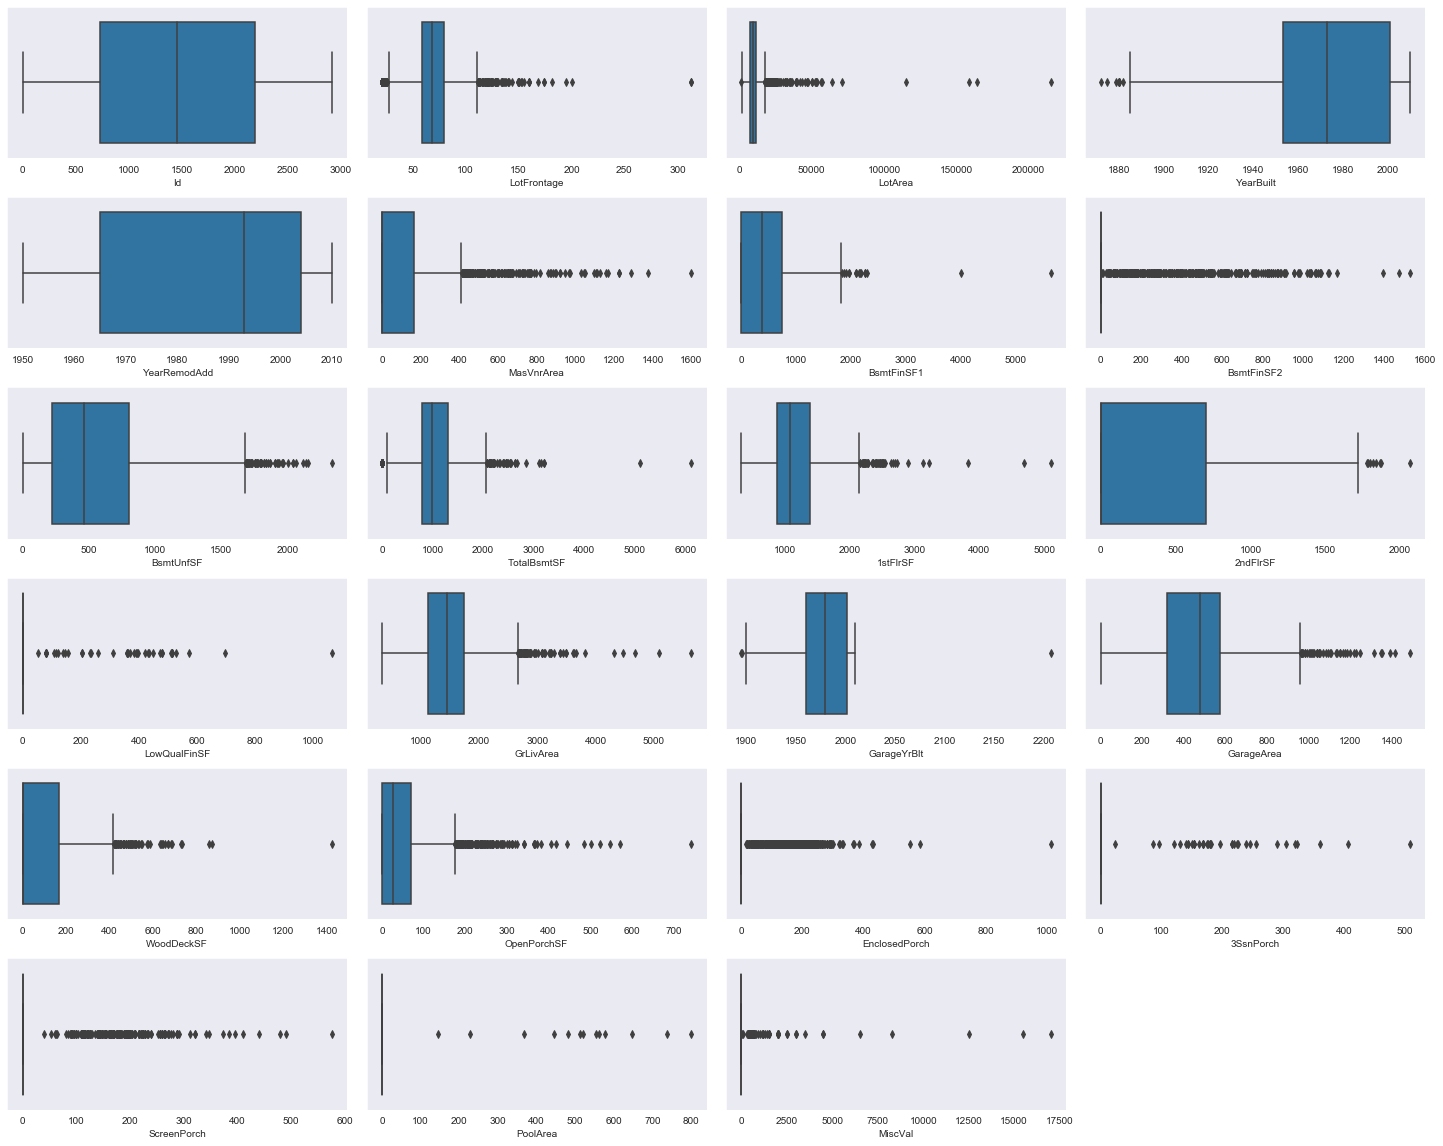

In [32]:
fig = plt.figure(figsize = (20,16))
for index, col in enumerate(num_hard):
    plt.subplot(6,4, index+1)
    sns.boxplot(num_feat.loc[:, col].dropna())
fig.tight_layout(pad = 1)

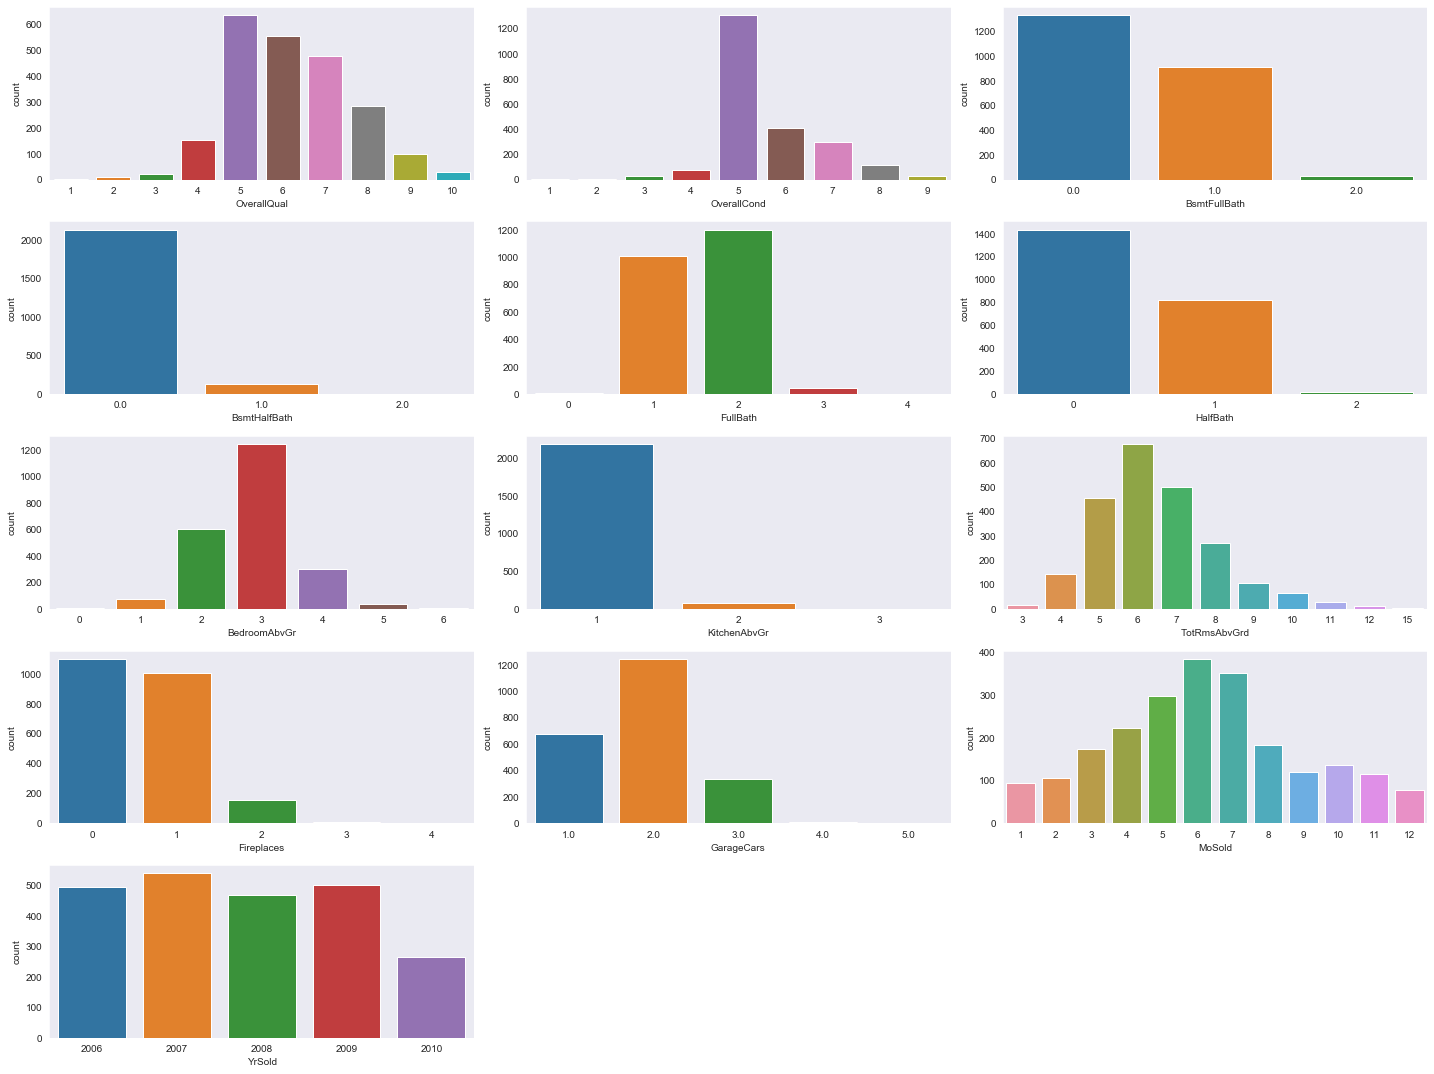

In [33]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(num_easy):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=num_feat.dropna())
fig.tight_layout(pad=1.0)

Достаточно большое кол-во признаков имеют редковстречающиеся значения, возможно придется каким-нибудь образом фильтровать данные, т.к. такие значения признаков не будут нести пользу для модели.

### Анализ категориальных признаков

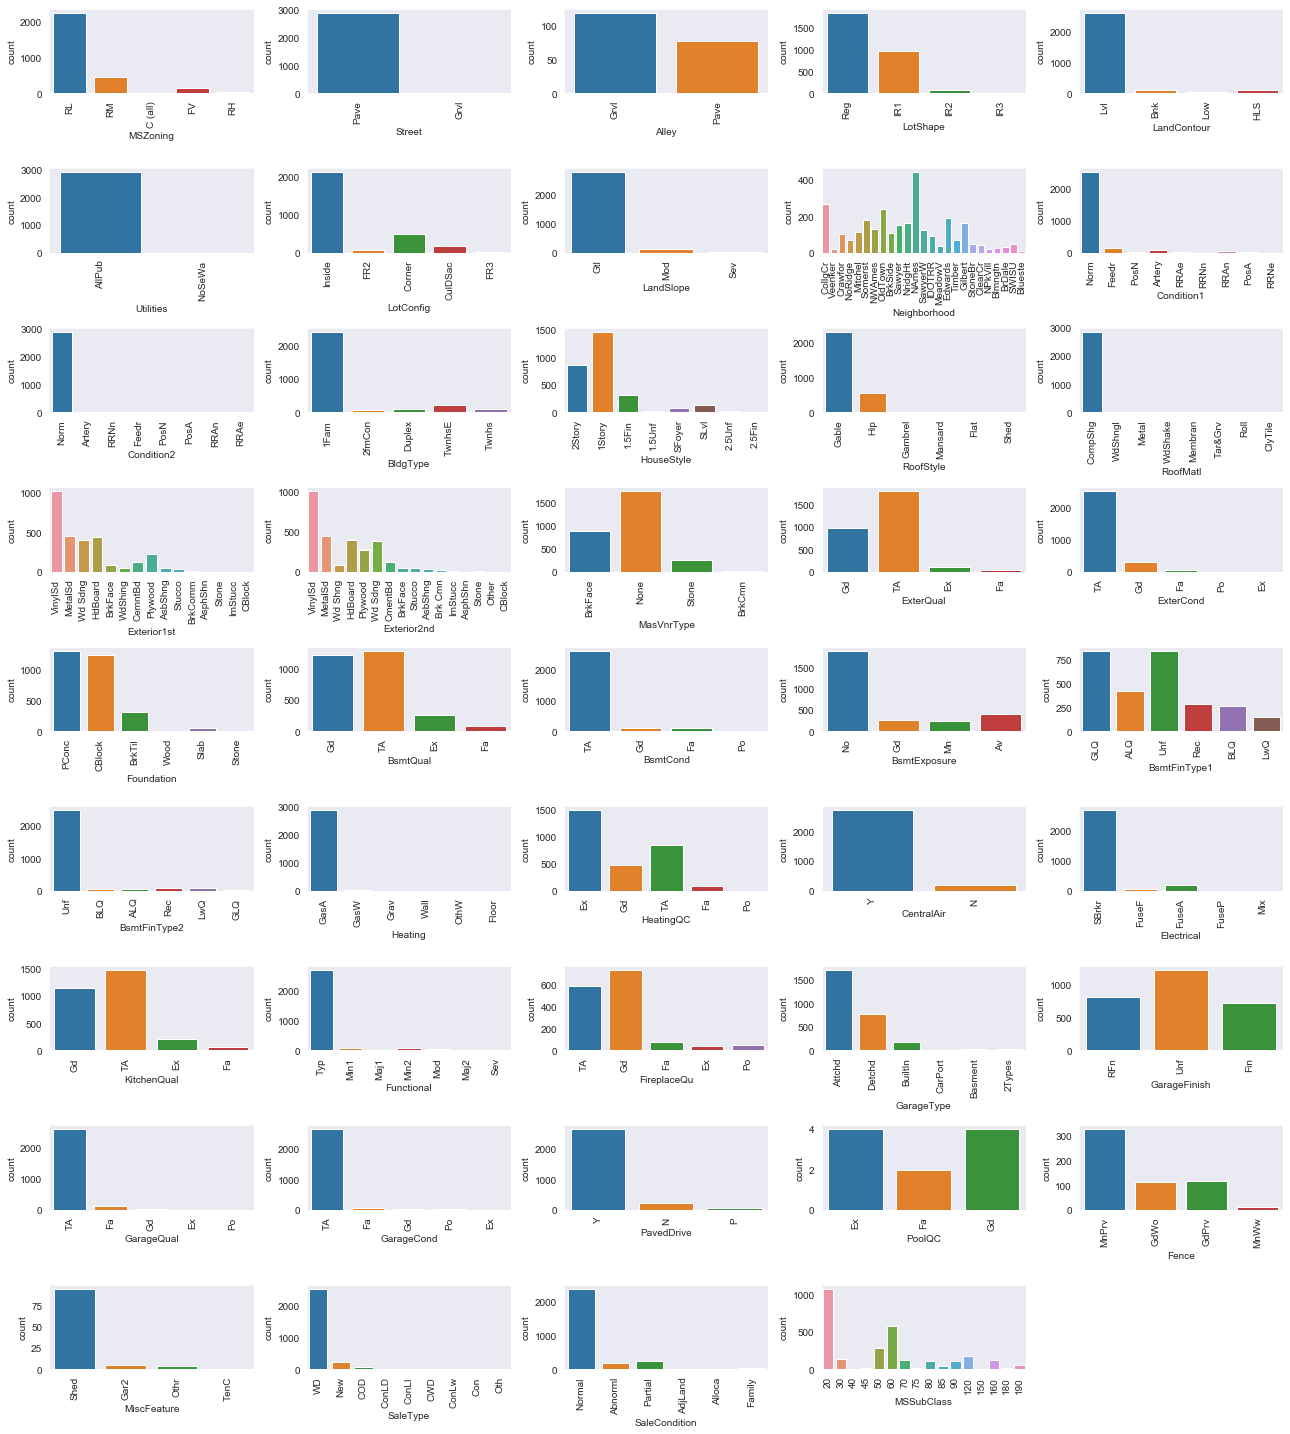

In [37]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_feat.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_feat.iloc[:,index], data=cat_feat.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)


Как мы видим, некоторые признаки имеют только одно значение, что так же делает их бессмысленными для модели обучения.